In [115]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import os
import sys
%matplotlib inline
import datetime

In [116]:
cab_data=pd.read_csv("cab_rides.csv")

In [117]:
weather_data=pd.read_csv("weather.csv.csv")

In [118]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [119]:
#cab_data=reduce_mem_usage(cab_data)

In [120]:
#weather_data=reduce_mem_usage(weather_data)

In [121]:
cab_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [122]:
weather_data.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [123]:
import datetime
cab_data['datetime']=pd.to_datetime(cab_data['time_stamp'])
cab_data

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,1970-01-01 00:25:44.952607890
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,1970-01-01 00:25:43.284023677
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,1970-01-01 00:25:43.366822198
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,1970-01-01 00:25:43.553582749
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,1970-01-01 00:25:43.463360223
...,...,...,...,...,...,...,...,...,...,...,...
693066,1.00,Uber,1543708385534,North End,West End,13.0,1.0,616d3611-1820-450a-9845-a9ff304a4842,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,1970-01-01 00:25:43.708385534
693067,1.00,Uber,1543708385534,North End,West End,9.5,1.0,633a3fc3-1f86-4b9e-9d48-2b7132112341,55c66225-fbe7-4fd5-9072-eab1ece5e23e,UberX,1970-01-01 00:25:43.708385534
693068,1.00,Uber,1543708385534,North End,West End,NaN,1.0,64d451d0-639f-47a4-9b7c-6fd92fbd264f,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,1970-01-01 00:25:43.708385534
693069,1.00,Uber,1543708385534,North End,West End,27.0,1.0,727e5f07-a96b-4ad1-a2c7-9abc3ad55b4e,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,1970-01-01 00:25:43.708385534


In [124]:
weather_data['date_time']=pd.to_datetime(weather_data['time_stamp'])
weather_data.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'time_stamp',
       'humidity', 'wind', 'date_time'],
      dtype='object')

In [125]:
cab_data.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime'],
      dtype='object')

In [126]:
weather_data.shape

(6276, 9)

In [127]:
cab_data.shape

(693071, 11)

In [128]:
a=pd.concat([cab_data,weather_data])

In [129]:
a.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,temp,location,clouds,pressure,rain,humidity,wind,date_time
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,1970-01-01 00:25:44.952607890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,1970-01-01 00:25:43.284023677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,1970-01-01 00:25:43.366822198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,1970-01-01 00:25:43.553582749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,1970-01-01 00:25:43.463360223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [130]:
a['day']=a.date_time.dt.day
a['hour']=a.date_time.dt.hour

In [131]:
a.tail()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,temp,location,clouds,pressure,rain,humidity,wind,date_time,day,hour
6271,NaN,NaN,1543819974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.72,North Station,0.89,1000.69,NaN,0.96,1.52,1970-01-01 00:00:01.543819974,1.0,0.0
6272,NaN,NaN,1543819974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.85,Northeastern University,0.88,1000.71,NaN,0.96,1.54,1970-01-01 00:00:01.543819974,1.0,0.0
6273,NaN,NaN,1543819974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.82,South Station,0.89,1000.70,NaN,0.96,1.54,1970-01-01 00:00:01.543819974,1.0,0.0
6274,NaN,NaN,1543819974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.78,Theatre District,0.89,1000.70,NaN,0.96,1.54,1970-01-01 00:00:01.543819974,1.0,0.0
6275,NaN,NaN,1543819974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,44.69,West End,0.89,1000.70,NaN,0.96,1.52,1970-01-01 00:00:01.543819974,1.0,0.0


In [132]:
a.fillna(0,inplace=True)

In [133]:
a.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,...,temp,location,clouds,pressure,rain,humidity,wind,date_time,day,hour
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


In [134]:
a.groupby('cab_type').count()

,distance,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,temp,location,clouds,pressure,rain,humidity,wind,date_time,day,hour
cab_type,,,,,,,,,,,,,,,,,,,,
0,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276
Lyft,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408,307408
Uber,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663,385663


<AxesSubplot:xlabel='cab_type'>

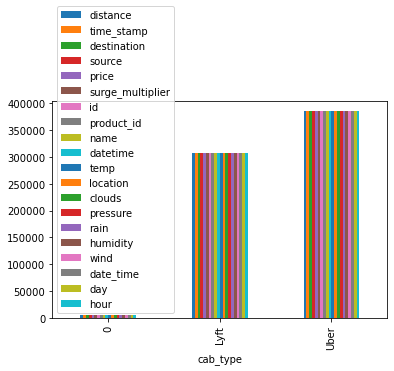

In [135]:
a.groupby('cab_type').count().plot.bar()

<AxesSubplot:>

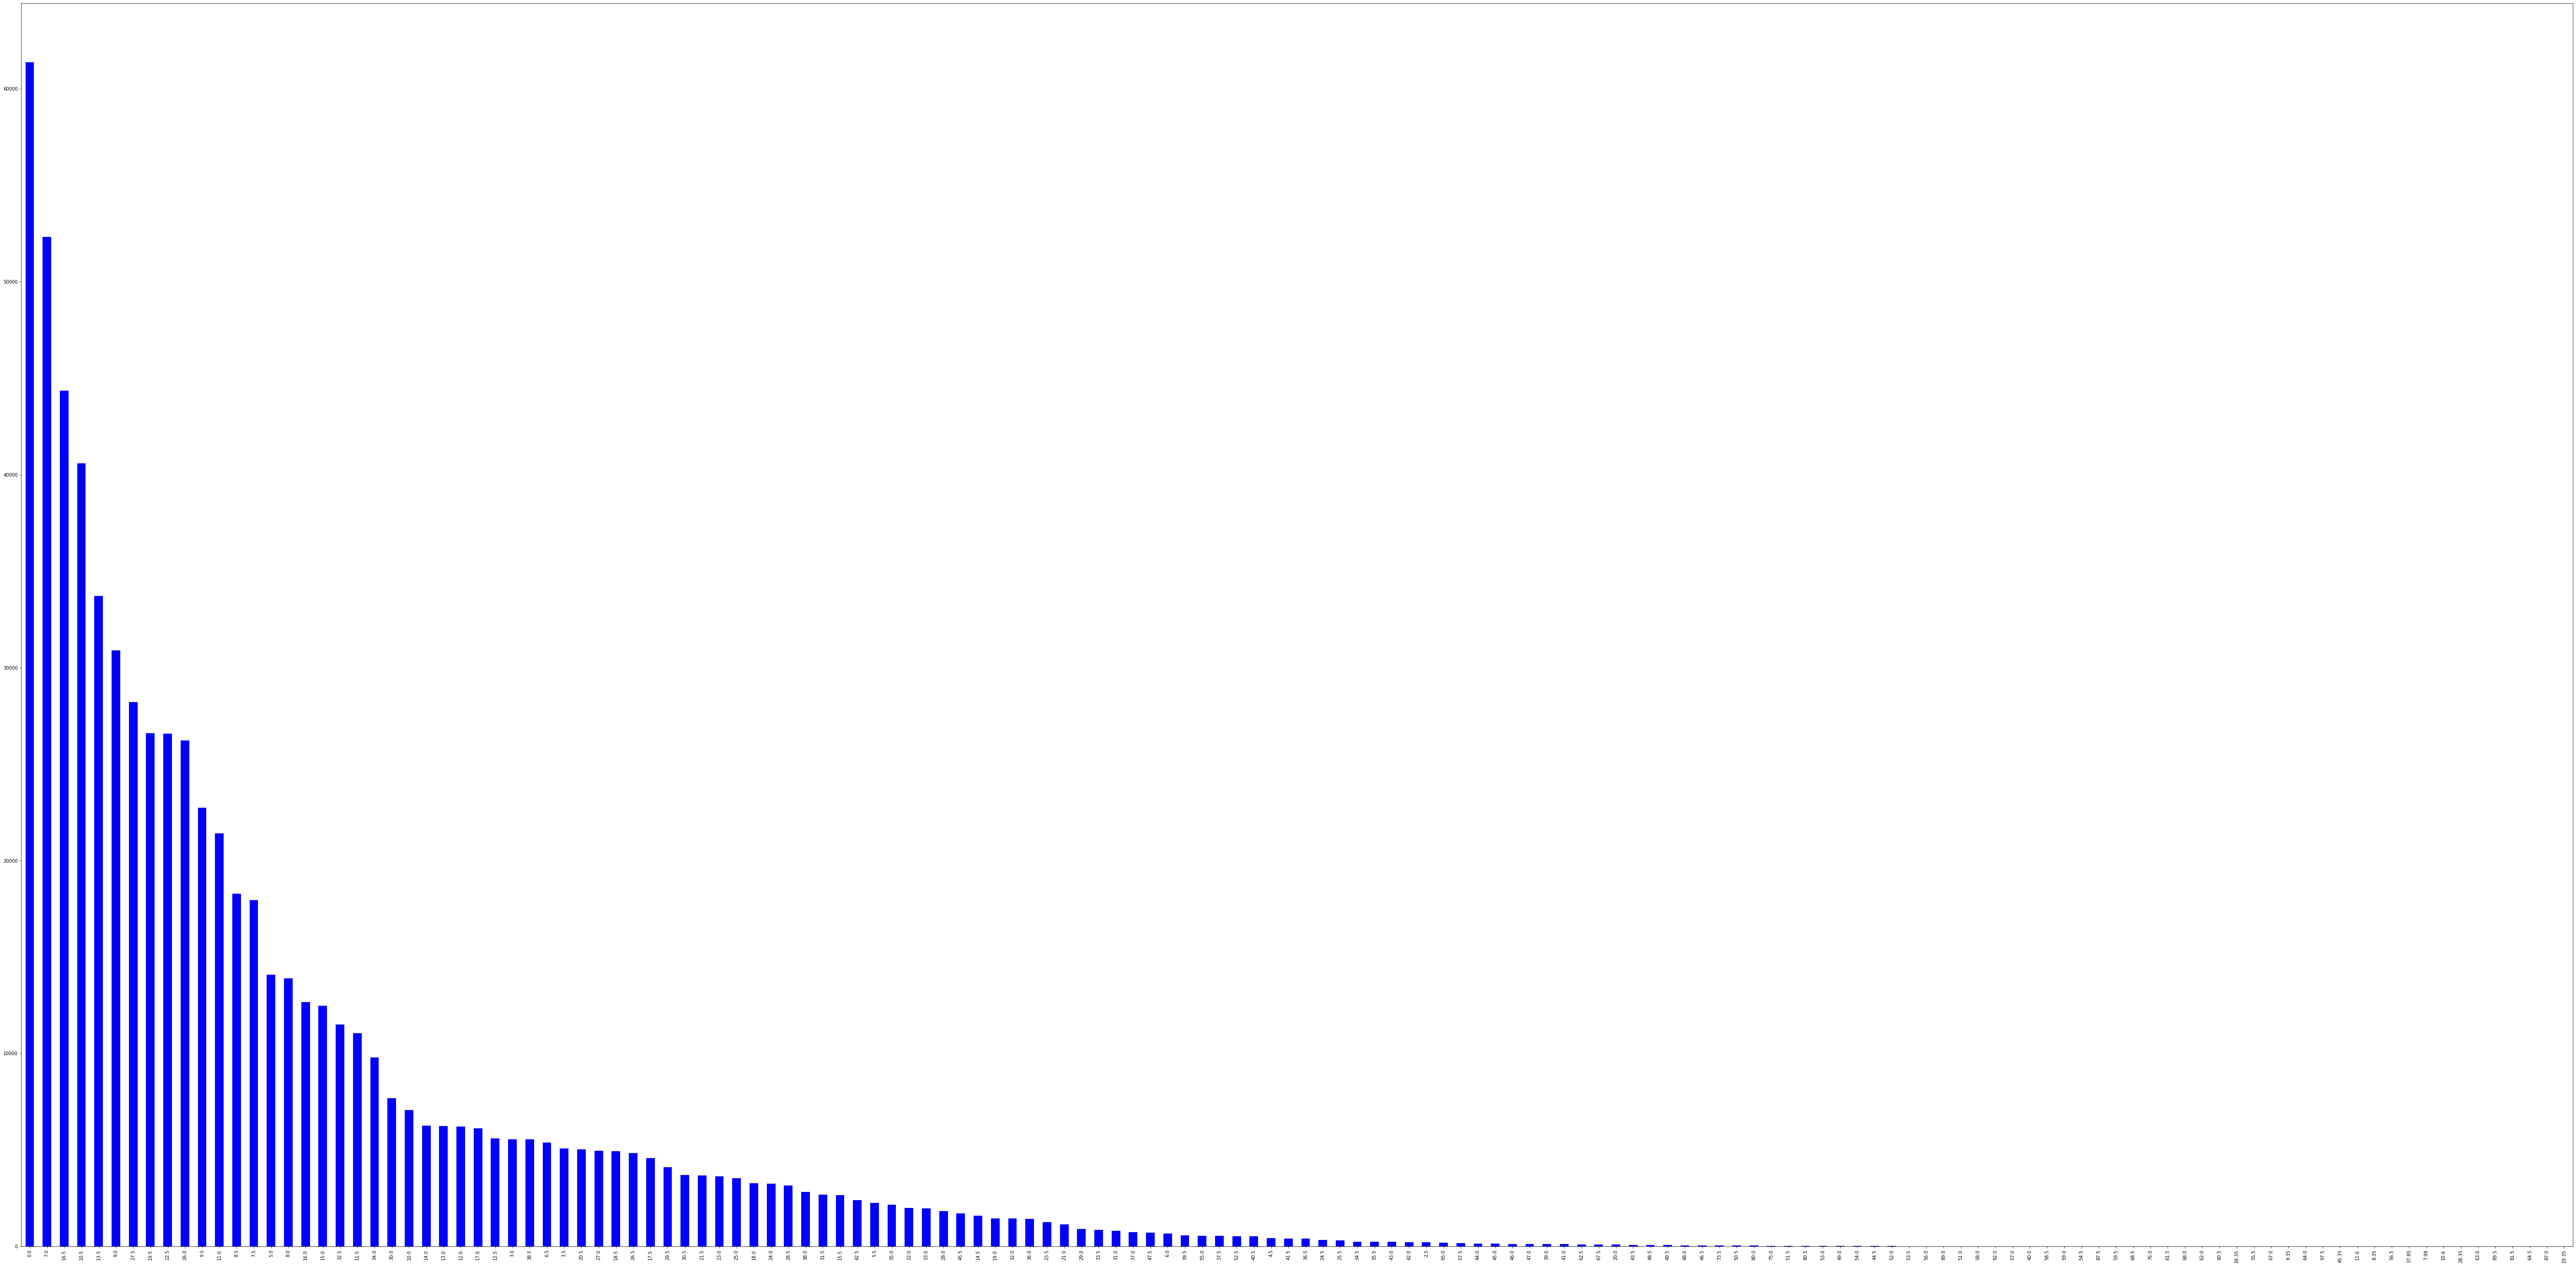

In [136]:
a['price'].value_counts().plot(kind='bar',figsize=(100,50),color='blue')


<AxesSubplot:>

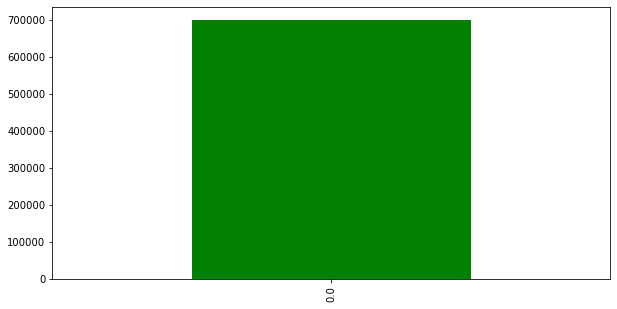

In [137]:
a['hour'].value_counts().plot(kind='bar',figsize=(10,5),color='green')

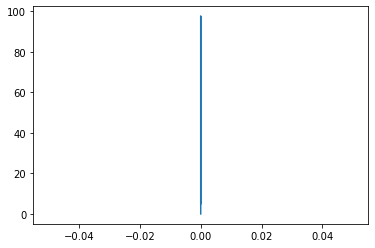

In [138]:
x=a['hour']
y=a['price']
plt.plot(x,y)
plt.show()

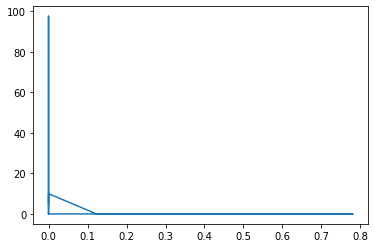

In [139]:
x=a['rain']
y=a['price']
plt.plot(x,y)
plt.show()

In [158]:
x1=a[['distance','temp','pressure','humidity','wind','rain','day','hour','surge_multiplier','clouds']]
y1=a['price']

In [159]:
from sklearn.model_selection import train_test_split
x_train,y_train, x_test,y_test= train_test_split(x1,y1, test_size=0.25,random_state=42)
linear=LinearRegression()
linear.fit(x_train,x_test)

LinearRegression()

In [160]:
prediction=linear.predict(y_train)
prediction

array([32.54791635, 14.75560763, 16.81696874, ..., 11.82898384,
       11.85443274, 13.22867348])

In [162]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':prediction})
df

,Actual,Predicted
81607,42.5,32.547916
354,0.0,14.755608
471801,32.5,16.816969
407645,27.5,10.480192
474760,27.5,10.556539
...,...,...
538489,7.5,10.709232
579511,13.5,15.519075
5421,9.0,11.828984
279982,8.0,11.854433
